In [1]:
from datasets import load_dataset
import torch
from torch.utils.data import Dataset
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, pipeline, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd

c:\Users\hp\Desktop\DS2\Natural Language Processing\project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
import csv

sentences = []
gold_labels = []
pred_labels = []

with open("combined_labels.csv", "r", encoding="utf-8") as f:
    combined_t = []
    combined_l = []

    reader = csv.reader(f)
    next(reader)

    for line in reader:
        token, label = line
        if token[:5]=="date:":
            continue
        elif token=="" and label == 'O' and len(combined_l)>0:
            if combined_t[0]=='':
                sentences.append(combined_t[1:])
                gold_labels.append(combined_l[1:])
            else:
                sentences.append(combined_t)
                gold_labels.append(combined_l)
            combined_t = []
            combined_l = []
        else:
            combined_t.append(token)
            combined_l.append(label)

    if combined_l:
        sentences.append(combined_t)
        gold_labels.append(combined_l)

In [8]:
NER_model = AutoModelForTokenClassification.from_pretrained("./saved_model")
print(NER_model.config.problem_type)
NER_model.config.problem_type = 'token_classification'
print(NER_model.config.problem_type)
NER_tokenizer = AutoTokenizer.from_pretrained("./saved_model")
ner_pipeline = pipeline("ner", model=NER_model, tokenizer=NER_tokenizer, aggregation_strategy="simple") 

Device set to use cpu


multi_label_classification
token_classification


In [39]:
for sent, tru in zip(sentences, gold_labels):
    
    encoding = NER_tokenizer(sent, is_split_into_words=True, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = NER_model(**encoding)

    # Get predicted class IDs
    predictions = torch.argmax(outputs.logits, dim=2)

    # Map back to word-level predictions
    predicted_labels = []
    word_ids = encoding.word_ids()

    for idx, word_id in enumerate(word_ids):
        if word_id is None:
            continue
        if idx == 0 or word_id != word_ids[idx - 1]:
            predicted_labels.append(NER_model.config.id2label[predictions[0, idx].item()])

    pred_labels.append(predicted_labels)

301

In [ ]:
from sklearn.metrics import accuracy_score

flat_gold = [label for sent in gold_labels for label in sent][:-1]
flat_pred = [label for sent in pred_labels for label in sent]

accuracy = accuracy_score(flat_gold, flat_pred)
print(f"Total accuracy: {accuracy:.4f}")

10950 10950
Total accuracy: 0.9067


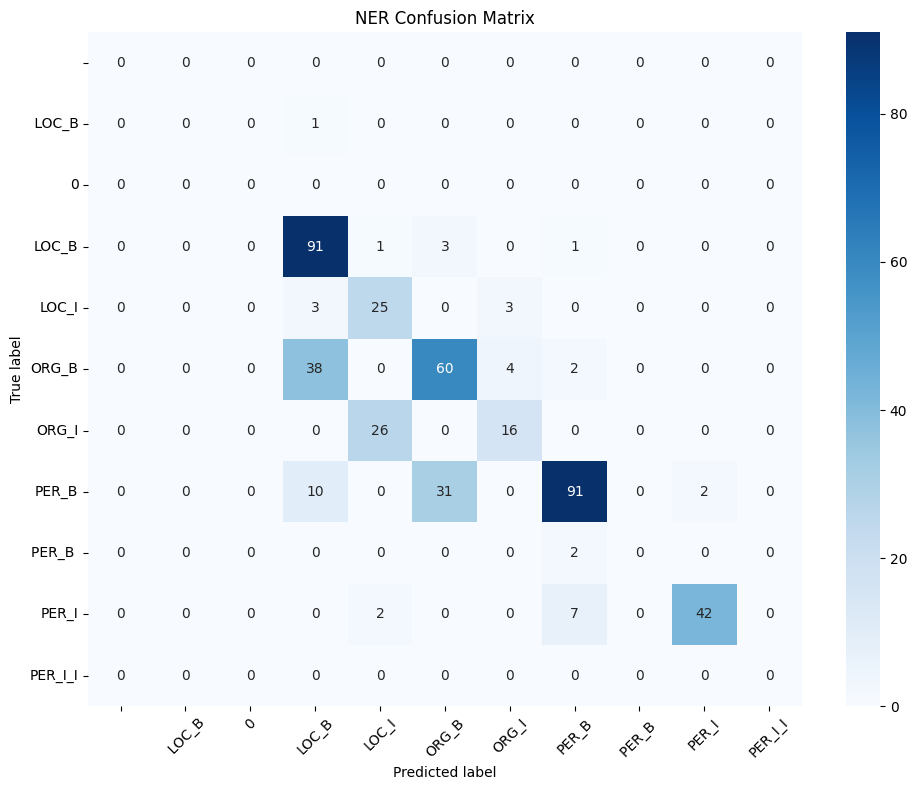

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

labels = sorted(set(flat_gold + flat_pred))
labels = [label for label in labels if label != 'O']

# Compute CM without "O"
cm = confusion_matrix(flat_gold, flat_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels),
            annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('NER Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [69]:
from sklearn.metrics import classification_report

# Make sure 'flat_gold' and 'flat_pred' are 1D lists of string labels
# If you want to exclude "O", filter them first
labels = sorted(set(flat_gold + flat_pred))
target_labels = [label for label in labels if label != 'O']

# Generate the report
print(classification_report(flat_gold, flat_pred, labels=target_labels, digits=4))

              precision    recall  f1-score   support

                 0.0000    0.0000    0.0000         1
       LOC_B     0.0000    0.0000    0.0000         1
           0     0.0000    0.0000    0.0000         7
       LOC_B     0.5322    0.8667    0.6594       105
       LOC_I     0.2874    0.6098    0.3906        41
       ORG_B     0.2970    0.3704    0.3297       162
       ORG_I     0.3556    0.0941    0.1488       170
       PER_B     0.7845    0.3669    0.5000       248
      PER_B      0.0000    0.0000    0.0000         2
       PER_I     0.7119    0.1077    0.1871       390
     PER_I_I     0.0000    0.0000    0.0000         1

   micro avg     0.4779    0.2881    0.3595      1128
   macro avg     0.2699    0.2196    0.2014      1128
weighted avg     0.5748    0.2881    0.3200      1128



c:\Users\hp\Desktop\DS2\Natural Language Processing\project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\Desktop\DS2\Natural Language Processing\project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\Desktop\DS2\Natural Language Processing\project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 